Sonar数据2类，60维，208个样本

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
connectionist_bench_sonar_mines_vs_rocks = fetch_ucirepo(id=151) 
  
# data (as pandas dataframes) 
X = connectionist_bench_sonar_mines_vs_rocks.data.features 
y = connectionist_bench_sonar_mines_vs_rocks.data.targets 

In [2]:
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute51,Attribute52,Attribute53,Attribute54,Attribute55,Attribute56,Attribute57,Attribute58,Attribute59,Attribute60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0033,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0241,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0156,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094


In [3]:
y.head()

,class
0,R
1,R
2,R
3,R
4,R


In [4]:
y['class'].unique()

array(['R', 'M'], dtype=object)

Fisher线性判别类

In [5]:
class Fisher:
    def __init__(self, category=[1, 2]):
        self.class1 = category[0]
        self.class2 = category[1]
    def calculate_mean(self, X, y, category='R'):
        data = pd.concat([X, y], axis=1)
        return data[data['class'] == category].drop('class', axis=1).mean().values.reshape((1, -1))
    def calculate_S(self, X, y, category='R'):
        mu = self.calculate_mean(X, y, category)
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        data = data - mu
        return data.T.dot(data)
    def calculate_y_mean(self, X, y, w, category='R'):
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        return float(w.T.dot(data.T).mean())
    def calculate_amount(self, X, y, category='R'):
        data = pd.concat([X, y], axis=1)
        data = data[data['class'] == category].drop('class', axis=1)
        return len(data)
    def fit(self, X, y):
        self.mu1 = self.calculate_mean(X, y, self.class1)
        self.mu2 = self.calculate_mean(X, y, self.class2)
        self.S1 = self.calculate_S(X, y, self.class1)
        self.S2 = self.calculate_S(X, y, self.class2)
        self.Sw = self.S1 + self.S2
        self.w_star = np.linalg.inv(self.Sw).dot((self.mu1 - self.mu2).T)
        self.mu1_ba = self.calculate_y_mean(X, y, self.w_star, self.class1)
        self.mu2_ba = self.calculate_y_mean(X, y, self.w_star, self.class2)
        self.N1 = self.calculate_amount(X, y, self.class1)
        self.N2 = self.calculate_amount(X, y, self.class2)
    def predict(self, xx, method='平均'):
        if method == '平均':
            # 平均
            self.y0 = (self.mu1_ba + self.mu2_ba) / 2
        else:
            # 加权平均
            self.y0 = (self.N1 * self.mu1_ba + self.N2 * self.mu2_ba) / (self.N1 + self.N2)
        self.y_tmp = self.w_star.T.dot(xx.T)
        self.y_tmp = np.where(self.y_tmp >= self.y0, 1, 0)
        self.y_predict = np.empty(self.y_tmp.shape, dtype=object)
        self.y_predict[self.y_tmp == 1] = self.class1
        self.y_predict[self.y_tmp == 0] = self.class2
        self.y_predict = self.y_predict.reshape((-1, 1))
        return self.y_predict
    def accuracy(self, y_true):
        return int(np.sum(np.array(y_true) == self.y_predict)) / len(self.y_predict)

5折交叉验证

In [6]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracy_with_dim = dict()
for dim in range(1, X.shape[1]+1):
    XX = X.iloc[:, :dim]
    accuracies = []
    for train_index, test_index in kf.split(XX):
        X_train, X_test = XX.iloc[train_index], XX.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model = Fisher(['R', 'M'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = model.accuracy(y_test)
        accuracies.append(accuracy)
    mean_accuracy = float(np.mean(accuracies))
    print("dim = ", dim, " 平均准确率:", mean_accuracy)
    accuracy_with_dim[dim] = mean_accuracy

dim =  1  平均准确率: 0.6055749128919861
dim =  2  平均准确率: 0.581068524970964
dim =  3  平均准确率: 0.5619047619047619
dim =  4  平均准确率: 0.586411149825784
dim =  5  平均准确率: 0.586411149825784
dim =  6  平均准确率: 0.586411149825784
dim =  7  平均准确率: 0.5721254355400697
dim =  8  平均准确率: 0.6249709639953542
dim =  9  平均准确率: 0.6440185830429733
dim =  10  平均准确率: 0.629732868757259
dim =  11  平均准确率: 0.6874564459930312
dim =  12  平均准确率: 0.6824622531939606
dim =  13  平均准确率: 0.6872241579558653
dim =  14  平均准确率: 0.7257839721254357
dim =  15  平均准确率: 0.6922183507549361
dim =  16  平均准确率: 0.7164924506387921
dim =  17  平均准确率: 0.721138211382114
dim =  18  平均准确率: 0.6968641114982578
dim =  19  平均准确率: 0.6923344947735192
dim =  20  平均准确率: 0.6826945412311266
dim =  21  平均准确率: 0.7015098722415797
dim =  22  平均准确率: 0.7017421602787456
dim =  23  平均准确率: 0.672938443670151
dim =  24  平均准确率: 0.6632984901277584
dim =  25  平均准确率: 0.673054587688734
dim =  26  平均准确率: 0.697212543554007
dim =  27  平均准确率: 0.7116144018583043
dim =  28  平均准确率: 0

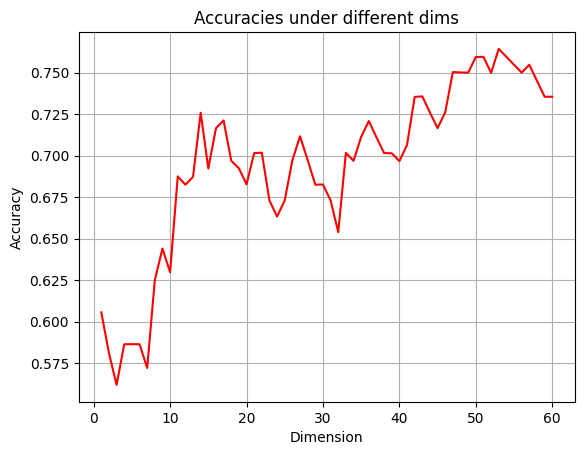

In [7]:
plt.plot(accuracy_with_dim.keys(), accuracy_with_dim.values(), color='r')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracies under different dims')
plt.grid()
plt.show()